In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Prepare data

In [13]:
bc = datasets.load_breast_cancer()
print(bc.keys())                # what’s inside
print(bc.feature_names)         # list of feature names
print(bc.target_names)          # ['malignant' 'benign']
print(bc.data.shape)            # (569, 30) → 569 samples, 30 features
print(bc.target[:10])

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
['malignant' 'benign']
(569, 30)
[0 0 0 0 0 0 0 0 0 0]


In [3]:
bc

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

/tmp/ipython-input-1280417681.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


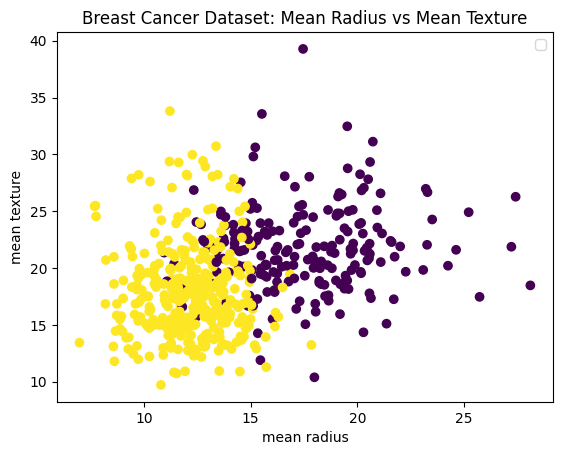

In [12]:
import matplotlib.pyplot as plt
plt.scatter(bc.data[:,0],bc.data[:,1],c=bc.target)
plt.xlabel(bc.feature_names[0])
plt.ylabel(bc.feature_names[1])
plt.title("Breast Cancer Dataset: Mean Radius vs Mean Texture")
plt.legend()
plt.show()

In [15]:
X, y = bc.data , bc.target
X.shape

(569, 30)

In [6]:
n_samples , n_features = X.shape
print(n_samples , n_features)

569 30


In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Scale

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [14]:
y_train = y_train.view(y_train.shape[0],1)
y_test = y_test.view(y_test.shape[0],1)

#MODEL

In [17]:
class LogisticRegression(nn.Module):
  def __init__(self,n_input_features):
    super(LogisticRegression,self).__init__()
    self.linear = nn.Linear(n_input_features,1)

  def forward(self,x):
    y_predicted = torch.sigmoid(self.linear(x))
    return y_predicted

model = LogisticRegression(n_features)

#loss and optimizer

In [18]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.01)

#Training LOOp

In [19]:
num_epochs = 100
for epoch in range(num_epochs):
  y_predicted = model(X_train)
  loss = criterion(y_predicted,y_train)

  #backward pass
  loss.backward()

  optimizer.step()

  optimizer.zero_grad()

  if (epoch+1)%10 == 0:
    print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 10, loss = 0.6338
epoch: 20, loss = 0.5126
epoch: 30, loss = 0.4382
epoch: 40, loss = 0.3881
epoch: 50, loss = 0.3519
epoch: 60, loss = 0.3244
epoch: 70, loss = 0.3027
epoch: 80, loss = 0.2851
epoch: 90, loss = 0.2704
epoch: 100, loss = 0.2580


In [21]:
with torch.no_grad():
  y_predicted = model(X_test)
  y_predicted_cls = y_predicted.round()
  acc = y_predicted_cls.eq(y_test).sum()/float(y_test.shape[0])
  print(f'accuracy = {acc:4f}')

accuracy = 0.973684


In [22]:
with torch.no_grad():
  y_predicted = model(X_test)
  y_predicted_cls = y_predicted.round()
  acc = y_predicted_cls.eq(y_test).sum()/float(y_test.shape[0])
  print(f'accuracy = {acc:4f}')
  print("\nPredictions for the first 5 samples in the test set:")
  for i in range(5):
      print(f"Sample {i+1}: Predicted Class = {y_predicted_cls[i].item()}, Actual Class = {y_test[i].item()}")

accuracy = 0.973684

Predictions for the first 5 samples in the test set:
Sample 1: Predicted Class = 1.0, Actual Class = 1.0
Sample 2: Predicted Class = 0.0, Actual Class = 0.0
Sample 3: Predicted Class = 0.0, Actual Class = 0.0
Sample 4: Predicted Class = 1.0, Actual Class = 1.0
Sample 5: Predicted Class = 1.0, Actual Class = 1.0
